<a href="https://colab.research.google.com/github/victoribeir0/Projetos_Machine_Learning/blob/main/gtzan_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classificação de gêneros musicais
Este notebook utliza o banco de dados GTZAN Dataset - Music Genre Classification, disponível no Kaggle.

O banco de dados fornece arquivos no formato wave, imagens do espectrograma e características extraídas (no formato csv) para cada arquivo de áudio.

Neste notebook será utilziado somente as imagens dos espectrograma.

Para classificação, será usada uma Rede Neural Convolucional.

### Comandos necessários para acessar o banco de dados:
Antes de executar estes comandos, adicione o arquivo .json (aqui no colab) disponibilizado pelo Kaggle para ter acesso aos bancos de dados hospedados lá.

Com estes comandos, é possível baixar e utilizar o dataset inteiro.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification
! unzip /content/gtzan-dataset-music-genre-classification.zip

## Importa as bilbiotecas a serem usadas

In [20]:
import shutil # Para organizar os arquivos, caso existam arquivos faltosos.
import os     # Para lidar com os arquivos.
import matplotlib.pyplot as plt 
#import matplotlib.image as mpimg 
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
from os.path import exists
#import pandas as pd

## Lidando com os dados faltosos
Nesta etapa é observado ser há arquivos faltando no diretório. Caso haja, o arquivo anterior é utilizado no lugar.

In [24]:
# Lida com os dados faltosos (copiando a imagem do arquivo anterior).

# Define as classes (gêneros) presentes no dataset.
classes = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

for c in classes:      # Para cada classe
  for i in range(100): # Para cada arquivo
  
    if i < 10:
      path = '/content/Data/images_original/' + c + '/' + c + '0000' + str(i) + '.png'
      if not os.path.exists(path): # Caso o arquivo não exista
          arquivo = c + '0000' + str(i) + '.png'
          print('Faltando: ' + arquivo)
          src = '/content/Data/images_original/' + c + '/' + c + '0000' + str(i-1) + '.png'
          dst = path
          shutil.copyfile(src, dst)
          os.rename(r,'/content/Data/images_original/' + c + '/' + c + '0000' + str(i-1) + '.png',r'/content/Data/images_original/' + c + '/' + c + '0000' + str(i) + '.png')          

    else:
      path = '/content/Data/images_original/' + c + '/' + c + '000' + str(i) + '.png'
      if not os.path.exists(path): # Caso o arquivo não exista
          arquivo = c + '000' + str(i) + '.png'
          print('Faltando: ' + arquivo)
          src = '/content/Data/images_original/' + c + '/' + c + '000' + str(i-1) + '.png'
          dst = path
          shutil.copyfile(src, dst)
          os.rename(r,'/content/Data/images_original/' + c + '/' + c + '000' + str(i-1) + '.png',r'/content/Data/images_original/' + c + '/' + c + '000' + str(i) + '.png')

## Separando os dados em treino e teste
Nesta etapa os dados são separados em treino e teste.

Cada gênero possui 100 arquivos de imagem com o espectrograma da música.

São selecionados 75 arquivos para treino e 25 para teste.

Os arquivos são selecionados aleatóriamente.

In [25]:
n_amostras_treino = 75
n_amostras_teste = 25
n_treino = n_amostras_treino*len(classes) # Núm. total de imagens para treino
n_teste = n_amostras_teste*len(classes)   # Núm. total de imagens para teste

ind_treino = list(range(100)) # Lista com todos entre 0 e 100
np.random.shuffle(ind_treino) # Torna a lista aleatória
ind_treino = ind_treino[0:n_amostras_treino] # Seleciona só as 75 primeiras amostras (treino)
ind_teste = np.setdiff1d(range(100), ind_treino, assume_unique=True) # Pega as amostras restantes (teste)

Nesta parte é definida uma função que irá transformar a imagem (arquivo png) em uma matriz.

In [26]:
# Seleciona os dados de treino e teste.
# n_total = Núm total de imagens a ser analisadas.
# ind = Índices aleatórios.
# classes = Lista com as classes (gêneros).
def get_data(n_total, ind, classes):
  data = np.zeros((n_total,288,432)) # Inicia a variável que irá conter os dados.
  j = 0

  for k in classes:  # Para cada gênero.
    for i in ind:    # Para cada índices aleatório.

      if i < 10: 
        path = '/content/Data/images_original/' + k + '/' + k + '0000' + str(i) + '.png'
        img = Image.open('/content/Data/images_original/' + k + '/' + k + '0000' + str(i) + '.png').convert('L')
        data[j,:,:] = np.array(img)
          
      elif i >= 10:
        path = '/content/Data/images_original/' + k + '/' + k + '000' + str(i) + '.png'
        img = Image.open('/content/Data/images_original/' + k + '/' + k + '000' + str(i) + '.png').convert('L')
        data[j,:,:] = np.array(img)

      j += 1
  
  data = data / 255.0 # Normaliza entre 0 e 1.
  return data

# Chama a função para o conjunto de treino e de teste.
train_images = get_data(n_treino, ind_treino, classes) # Treino
test_images = get_data(n_teste, ind_teste, classes)    # Teste

# Mostra as dimensões dos dados (Núm. de imagens, Núm. de linhas, Núm. de colunas).
print(train_images.shape) 
print(test_images.shape)

(750, 288, 432)
(250, 288, 432)


## Removendo as partes da imagem sem informação
Parte da imagem presente no banco de dados está em branco e iremos remover essa parte.

Além disso, os dados também são colocados no padrão da Rede Neural Recorrente.

(250, 217, 336, 1)

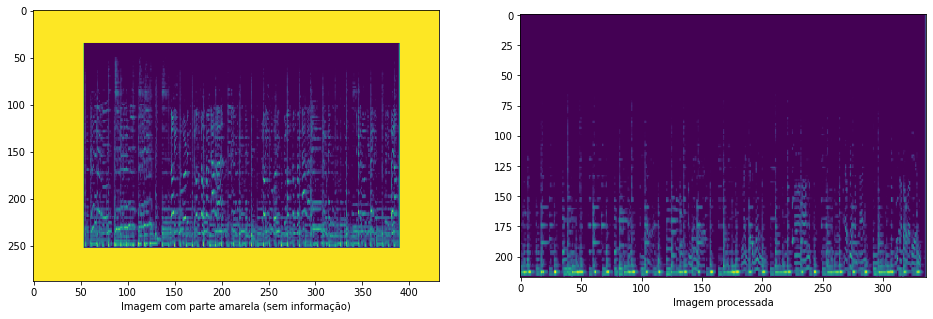

In [34]:
plt.figure(figsize=(16,26))
plt.subplot(1,2,1)
plt.imshow(train_images[0])
plt.xlabel('Imagem com parte amarela (sem informação)')

train_images_cut = train_images[:,35:252,54:390] # Remove as partes sem informação.
test_images_cut = test_images[:,35:252,54:390] 
test_images_cut.shape

plt.subplot(1,2,2)
plt.imshow(test_images_cut[0])
plt.xlabel('Imagem processada')

# Coloca no padrão da Rede Neural Convolucional do TensorFlow.
train_images_cut = train_images_cut.reshape(-1, 217, 336, 1)
test_images_cut = test_images_cut.reshape(-1, 217, 336, 1)
test_images_cut.shape

## Definindo os rótulos
Os rótulos são necessários para que a rede consiga otimizar os parâmetros.

São definidos 10 rótulos inteiros entre 0 e 9.

In [35]:
# Função para definir os rótulos.
def get_rotulo(n_dados_total,n_dados):
  label = np.zeros((n_dados_total,))
  k = 0
  for i in range(10): # 10 Classes.
    for j in range(n_dados):
      label[k] = i  
      k += 1
  return label

# Chama a função para a rótulos de treino e teste.
train_labels = get_rotulo(n_treino,n_amostras_treino) # Treino
test_labels = get_rotulo(n_teste,n_amostras_teste)    # Teste

# Mostra as dimensões dos rótulos.
print(train_labels.shape)
print(test_labels.shape)

(750,)
(250,)


## Definição do modelo de classificação
É utilizada uma Rede Neural Convolucional com diversas camadas.

In [36]:
model = keras.Sequential([
  # Aqui é definida cada camada de entrada, com a dimensão da entrada.
  keras.layers.InputLayer(input_shape=(217,336,1)), 
  
  keras.layers.Conv2D(32,(5,5),activation='relu'),
  keras.layers.MaxPooling2D((3,3)),
  keras.layers.Conv2D(32,(5,5),activation='relu'),
  keras.layers.MaxPooling2D((3,3)),
  keras.layers.Conv2D(32,(5,5),activation='relu'),
  keras.layers.MaxPooling2D((3,3)),
  keras.layers.Conv2D(64,(3,3),activation='relu'),       
  keras.layers.MaxPooling2D((2,2)),  
  keras.layers.Flatten(),
  keras.layers.Dense(32, activation='relu'),            
  keras.layers.Dense(10, activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 213, 332, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 71, 110, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 67, 106, 32)       25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 35, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 31, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 10, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 8, 64)         

## Otimização dos parâmetros

In [ ]:
history = model.fit(train_images_cut, train_labels, epochs=15, validation_data=(test_images_cut,test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(test_images_cut,  test_labels, verbose=2)